# FAOSTAT North America
We extract the datasets of some crops for the US and Canada. The goal of the notebook is to perform an analysis of the dependency between crop yield and climatic variables like temperature anomalies, precipitation anomalies, $CO_2$ concentration, and human inputs such as the use of natural and synthetic fertilizers.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score 
import statsmodels.api as sm
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import dates
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## Crops

In [2]:
year_index = pd.date_range('1961','2023', freq='Y')
print('Start: {}\nEnd: {}'.format(year_index[0], year_index[len(year_index) - 1]))

Start: 1961-12-31 00:00:00
End: 2022-12-31 00:00:00


In [3]:
crops_us_canada_path = 'data/FAOSTAT_US_Canada.csv'
crops_us_canada_path_tmp_df = pd.read_csv(crops_us_canada_path, usecols=['Area', 'Year', 'Item', 'Year', 'Value'])
crops_us_canada_path_tmp_df.head(2)

,Area,Item,Year,Value
0,Canada,Maize (corn),1961,45822
1,Canada,Maize (corn),1962,47721


In [4]:
maize_us_df = crops_us_canada_path_tmp_df[(crops_us_canada_path_tmp_df['Item'] == 'Maize (corn)') \
                                                      & (crops_us_canada_path_tmp_df['Area'] == 'United States of America')]
maize_us_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_us_df.set_index(year_index, inplace=True)
maize_us_df.drop(['Area', 'Item', 'Year'], axis=1, inplace=True)
maize_us_df

,Maize Yield (100g/ha)
1961-12-31,39184
1962-12-31,40621
1963-12-31,42596
1964-12-31,39498
1965-12-31,46492
...,...
2018-12-31,110746
2019-12-31,105104
2020-12-31,107605
2021-12-31,110895


In [5]:
maize_canada_df = crops_us_canada_path_tmp_df[(crops_us_canada_path_tmp_df['Item'] == 'Maize (corn)') \
                                                      & (crops_us_canada_path_tmp_df['Area'] == 'Canada')]
maize_canada_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_canada_df.set_index(year_index, inplace=True)
maize_canada_df.drop(['Area', 'Item', 'Year'], axis=1, inplace=True)
maize_canada_df

,Maize Yield (100g/ha)
1961-12-31,45822
1962-12-31,47721
1963-12-31,41108
1964-12-31,50636
1965-12-31,50061
...,...
2018-12-31,97049
2019-12-31,92364
2020-12-31,96317
2021-12-31,99958


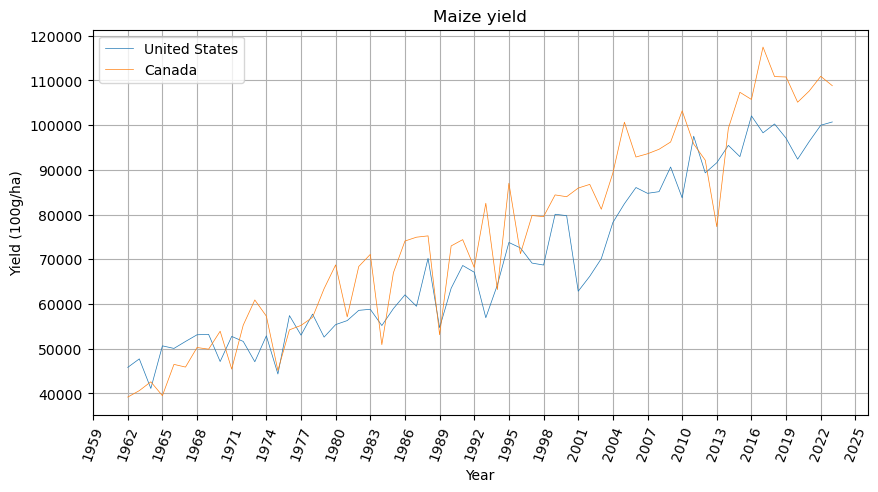

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Maize yield')
ax.set_xlabel('Year')
ax.set_ylabel('Yield (100g/ha)')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_maize_us = ax.plot(maize_canada_df, linewidth=0.5, label='United States')
plt_maize_canada = ax.plot(maize_us_df, linewidth=0.5, label='Canada')
plt.legend(loc='upper left')

## Temperature anomalies

### United States
The temperatures for the US are available from the [EPA website](https://www.epa.gov/climate-indicators/climate-change-indicators-us-and-global-temperature) and from [FAOSTAT](https://www.fao.org/faostat/en/#data/ET) (Land, Inputs and Sustainability -> Climate Change Indicators), in this section we use the data from EPA. According to EPA, the temperature in the US has risen at an average rate of 0.17°F (0.106 °C) per decade.

In [13]:
temperatures_us_path = 'data/EPA_temperature_US_prepared.csv'
temperatures_us_df = pd.read_csv(temperatures_us_path, skiprows=0)
temperatures_us_df

,Year,Anomaly,Lower troposphere (measured by satellite) (UAH),Lower troposphere (measured by satellite) (RSS)
0,1901,-0.15,NaN,NaN
1,1902,-0.43,NaN,NaN
2,1903,-1.40,NaN,NaN
3,1904,-0.86,NaN,NaN
4,1905,-1.02,NaN,NaN
...,...,...,...,...
116,2017,2.53,2.219907,2.365114
117,2018,1.50,1.610907,1.803214
118,2019,0.66,1.094907,1.197364
119,2020,2.35,1.937907,2.297464


Since the temperature data does not contain the value for the year 2022, we use the mean of the anomalies of the last three years. 

In [14]:
temperature_anomaly_2022 = round(temperatures_us_df['Anomaly'][-3:].mean(), 2)
temperature_anomaly_2022

1.83

In [15]:
temperature_anomaly_2022_df = {'Year': 2022, 'Anomaly': temperature_anomaly_2022}
temperature_anomaly_2022_df

{'Year': 2022, 'Anomaly': 1.83}

In [16]:
temperatures_us_df.loc[temperatures_us_df.shape[0]] = temperature_anomaly_2022_df
temperatures_us_df.tail(2)

,Year,Anomaly,Lower troposphere (measured by satellite) (UAH),Lower troposphere (measured by satellite) (RSS)
120,2021,2.49,2.024907,2.496664
121,2022,1.83,NaN,NaN


In [17]:
temperatures_us_df.set_index(pd.date_range('1901', '2023', freq='Y'), inplace=True)
temperatures_us_df.drop('Year', axis=1, inplace=True)
temperatures_us_df.head(2)

,Anomaly,Lower troposphere (measured by satellite) (UAH),Lower troposphere (measured by satellite) (RSS)
1901-12-31,-0.15,NaN,NaN
1902-12-31,-0.43,NaN,NaN


In [18]:
temperatures_us_df['1961':]

,Anomaly,Lower troposphere (measured by satellite) (UAH),Lower troposphere (measured by satellite) (RSS)
1961-12-31,-0.15,NaN,NaN
1962-12-31,-0.12,NaN,NaN
1963-12-31,0.24,NaN,NaN
1964-12-31,-0.35,NaN,NaN
1965-12-31,-0.33,NaN,NaN
...,...,...,...
2018-12-31,1.50,1.610907,1.803214
2019-12-31,0.66,1.094907,1.197364
2020-12-31,2.35,1.937907,2.297464
2021-12-31,2.49,2.024907,2.496664


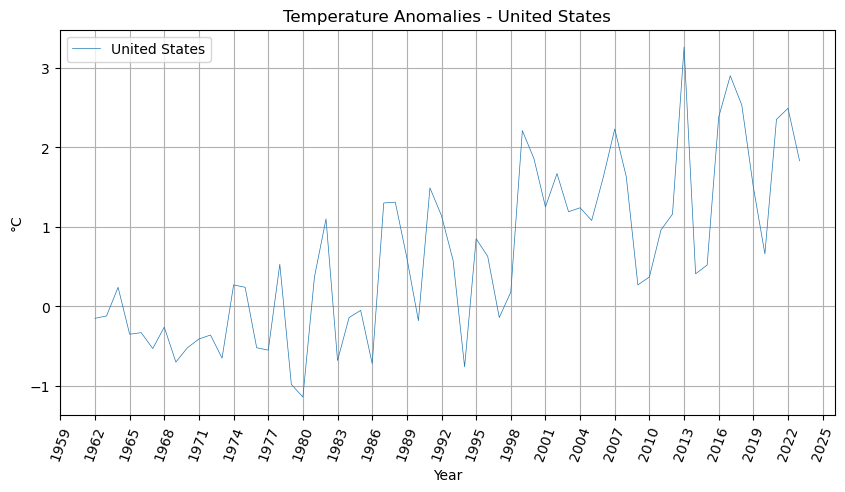

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Temperature Anomalies - United States')
ax.set_xlabel('Year')
ax.set_ylabel('°C')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_temperature_us = ax.plot(temperatures_us_df['Anomaly']['1961':], linewidth=0.5, label='United States')
plt.legend(loc='upper left')

In [34]:
y_temp_us = temperatures_us_df['Anomaly']
x = np.arange(0,122)
X = sm.add_constant(x)
model_temp_us = sm.OLS(y, X)
results_temp_us = model_temp_us.fit()
print(results_temp_us.summary())

                            OLS Regression Results                            
Dep. Variable:                Anomaly   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.77
Date:                Tue, 21 May 2024   Prob (F-statistic):           0.000508
Time:                        10:57:51   Log-Likelihood:                -660.96
No. Observations:                 122   AIC:                             1326.
Df Residuals:                     120   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.9695      9.895     -2.523      0.0

In [35]:
print("Parameters: ", results_temp_us.params)
print("R2: ", results_temp_us.rsquared)

Parameters:  const   -24.969490
x1        0.505117
dtype: float64
R2:  0.09617793296501498


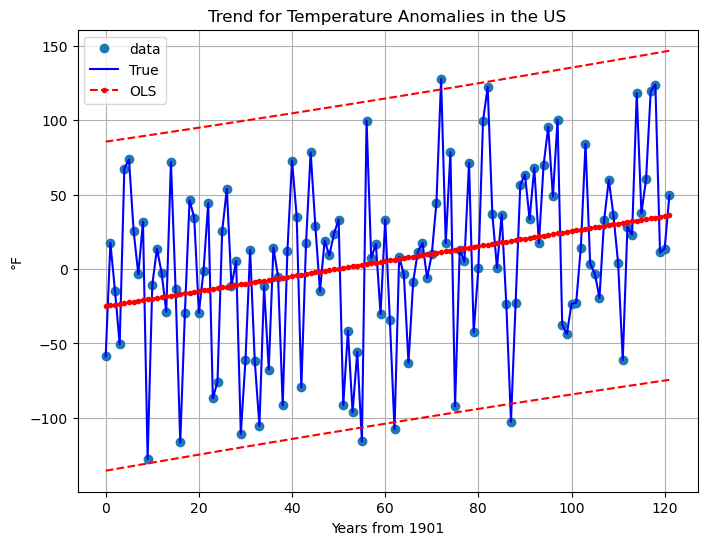

In [36]:
pred_ols = results_temp_us.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True)
ax.set_title('Trend for Temperature Anomalies in the US')
ax.set_xlabel('Years from 1901')
ax.set_ylabel('°F')
ax.plot(x, y, "o", label="data")
ax.plot(x, y, "b-", label="True")
ax.plot(x, results_temp_us.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

## Precipitation anomalies

### United States
The annual precipitations for the US are available from the [EPA website](https://www.epa.gov/climate-indicators/climate-change-indicators-us-and-global-precipitation). The precipitations for Canada are not available for the full country so they should be computed using the observations from the stations located on the territory. According to EPA, we should see an increase in the precipitations with a rate of 5.08 mm per decade.

In [24]:
precipitations_us_path = 'data/EPA_precipitations_US.csv'
precipitations_us_df = pd.read_csv(precipitations_us_path, skiprows=6)
precipitations_us_df

,Year,Anomaly
0,1901,-2.31
1,1902,0.69
2,1903,-0.58
3,1904,-1.99
4,1905,2.66
...,...,...
116,2017,2.37
117,2018,4.71
118,2019,4.88
119,2020,0.44


Since the precipitation data does not contain the value for the year 2022, we use the mean of the anomalies of the last three years. 

In [25]:
precipitation_anomaly_2022 = round(precipitations_us_df['Anomaly'][-3:].mean(), 2)
precipitation_anomaly_2022

1.95

In [26]:
precipitation_anomaly_2022_df = {'Year': 2022, 'Anomaly': precipitation_anomaly_2022}
precipitation_anomaly_2022_df

{'Year': 2022, 'Anomaly': 1.95}

In [27]:
precipitations_us_df.loc[precipitations_us_df.shape[0]] = precipitation_anomaly_2022_df
precipitations_us_df.tail(2)

,Year,Anomaly
120,2021,0.54
121,2022,1.95


In [28]:
precipitations_us_df.set_index(pd.date_range('1901', '2023', freq='Y'), inplace=True)
precipitations_us_df.drop('Year', axis=1, inplace=True)
precipitations_us_df.head(2)

,Anomaly
1901-12-31,-2.31
1902-12-31,0.69


We multiply the precipitation values in inch by a constant to transform them in mm.

In [31]:
precipitations_us_df['Anomaly'] = precipitations_us_df['Anomaly'] * 25.4

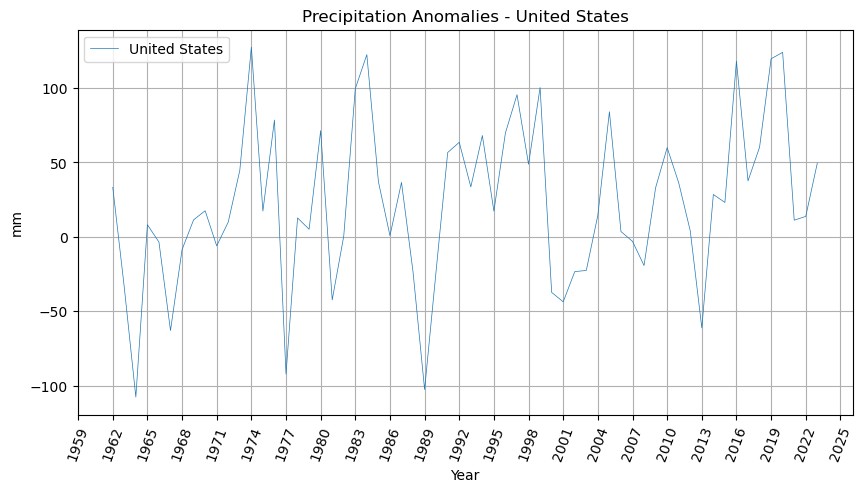

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Precipitation Anomalies - United States')
ax.set_xlabel('Year')
ax.set_ylabel('mm')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_precipitation_us = ax.plot(precipitations_us_df['1961':], linewidth=0.5, label='United States')
plt.legend(loc='upper left')

In [37]:
y_precip_us = precipitations_us_df['Anomaly']
x = np.arange(0,122)
X = sm.add_constant(x)
model_precip_us = sm.OLS(y, X)
results_precip_us = model_precip_us.fit()
print(results_precip_us.summary())

                            OLS Regression Results                            
Dep. Variable:                Anomaly   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     12.77
Date:                Tue, 21 May 2024   Prob (F-statistic):           0.000508
Time:                        11:01:24   Log-Likelihood:                -660.96
No. Observations:                 122   AIC:                             1326.
Df Residuals:                     120   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.9695      9.895     -2.523      0.0

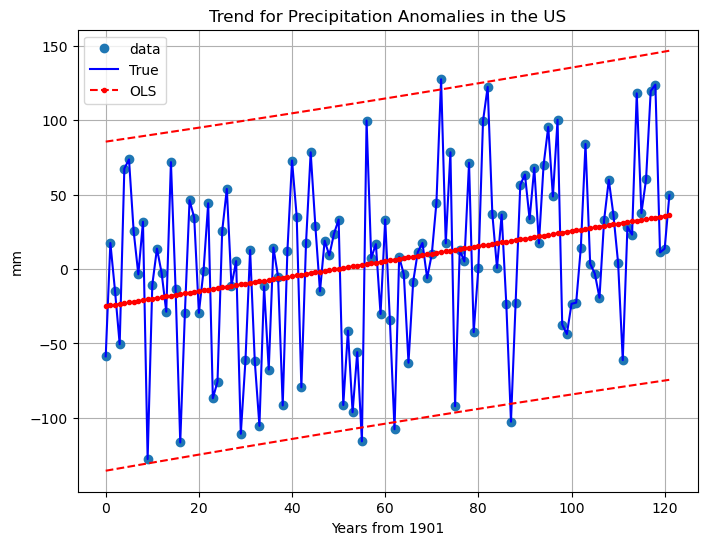

In [39]:
pred_ols = results_precip_us.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True)
ax.set_title('Trend for Precipitation Anomalies in the US')
ax.set_xlabel('Years from 1901')
ax.set_ylabel('mm')
ax.plot(x, y, "o", label="data")
ax.plot(x, y, "b-", label="True")
ax.plot(x, results_precip_us.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")